# Gradient Descent and Optimization

## Objectives

 * Explain how gradient descent works
 * Use gradient descent to optimize the cost function for logistic regression
 * Explain the advantage of stochastic gradient descent
 * Implement stochastic gradient descent

## Agenda

 * Motivation
 * Math
 * Examples
 * Difficulties
 * Stochastic gradient descent
 * Newton's method

Throughout machine learning we have a constant goal of trying to find the model that best predicts the target from the features. We generally define "best" as minimizing some cost function (or maximizing a score function). In the case of linear regression (without regularization), we can do that by solving an equation exactly, but in almost every other case that's not possible.

We'll start with linear regression anyway, since that's simple, and start in one dimension. First, some fake data.

In [3]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
npts = 25
x = stats.uniform(0, 10).rvs(npts)
y = x * 0.2 + 0.5 + stats.norm(0, 0.3).rvs(npts)

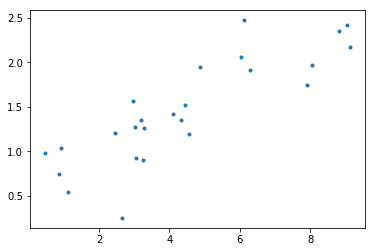

In [5]:
fig, ax = plt.subplots()
ax.plot(x, y, '.')

The loss function for linear regression is

$$\mathcal{L} = \sum_i (\beta_0 + \beta_1 x_i - y_i)^2$$

where $x_i$ are the values for our (one) feature and $y_i$ are the values for the target.

We want to find the values of $\beta_0$ and $\beta_1$ such that this loss function $\mathcal{L}$ is as small as possible.

The way we can do this is figure out which direction we can change the coefficients to make $\mathcal{L}$ smaller. We adjust the coefficients slightly in the direction, recalculate the direction, re-adjust, and repeat, again and again until we converge.

### Calculus, in a few minutes

A derivative of a function (you should recall) is infinitesimal change in that function with an infinitesimal change in the argument.

**Question:** what is $\frac{df}{dx}$ for the following functions?

 * $f(x) = x$
 * $f(x) = x^2$
 * $f(x) = x^3$
 * $f(x) = 2x^2 - 3x - 12$
 * $f(x) = e^x$
 * $f(x) = xe^x$

When we have a function with multiple arguments, we take a partial  partial derivative with respect to each argument, which is done by treating all the other variables as constant.

**Question:** what are $\frac{\partial f}{\partial x}$ and $\frac{\partial f}{\partial y}$ for the following functions?

 * $f(x, y) = x^2 + y^2$
 * $f(x, y) = xy^2 + 3x^2y^2 + ye^x$
 
The vector $(\frac{\partial f}{\partial x}, \frac{\partial f}{\partial y})$ is called a *gradient*, and is in the direction of greatest increase of the function. The opposite direction is the greatest decrease.

**Exercise:** work out the gradient of the loss function.

$$\mathcal{L} = \sum_i (\beta_0 + \beta_1 x_i - y_i)^2$$

So: the way gradient descent works is
 * Choose a starting point, a **learning rate**, and a threshold
 * Repeatedly:
     * Calculate the gradient at the current point,
     * Multiply the gradient by the negative of the learning rate
     * Add that to the current point to find a new point
     * Repeat until within the threshold
    
 

Let's do this all graphically. First, we'll make a contour plot of the loss function.

In [6]:
beta0, beta1 = np.meshgrid(np.arange(-10, 10, 0.05), np.arange(-5, 5, 0.05))
loss = ((beta0 + beta1 * x.reshape(-1, 1, 1) - y.reshape(-1, 1, 1))**2).sum(axis=0)

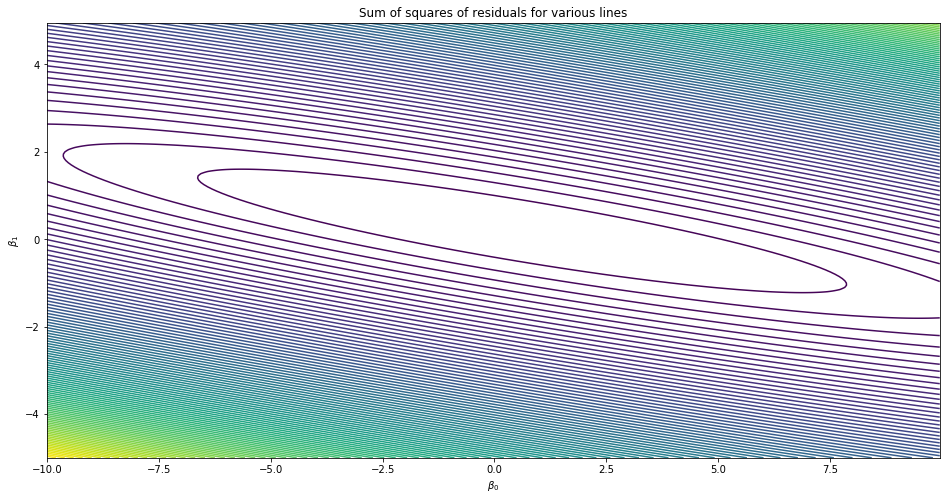

In [7]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.contour(beta0, beta1, loss, np.linspace(loss.min(), loss.max(), 100))
ax.set_xlabel(r"$\beta_0$")
ax.set_ylabel(r"$\beta_1$")
ax.set_title("Sum of squares of residuals for various lines")

The contour lines are lines of constant loss. Perpendicular to these is the direction of greatest slope. This is the gradient of the loss function, the vector of derivatives in each direction.

The partial derivatives of the loss function

$$\mathcal{L} = \sum_i (\beta_0 + \beta_1 x_i - y_i)^2$$

is

$$\frac{\partial\mathcal{L}}{\partial\beta_0} = 2 \sum_i (\beta_0 + \beta_1 x_i - y_i)$$

$$\frac{\partial\mathcal{L}}{\partial\beta_1} = 2 \sum_i x_i (\beta_0 + \beta_1 x_i - y_i)$$

In [8]:
def gradient(beta):
    return np.array((2*(beta[0] + beta[1]*x - y).sum(), 
                     2*(x * (beta[0] + beta[1]*x - y)).sum()))

In [9]:
points = [np.array((-8,0))]
alpha = 0.0011
for _ in range(20):
    points.append(points[-1] -
                  alpha * gradient(points[-1]))

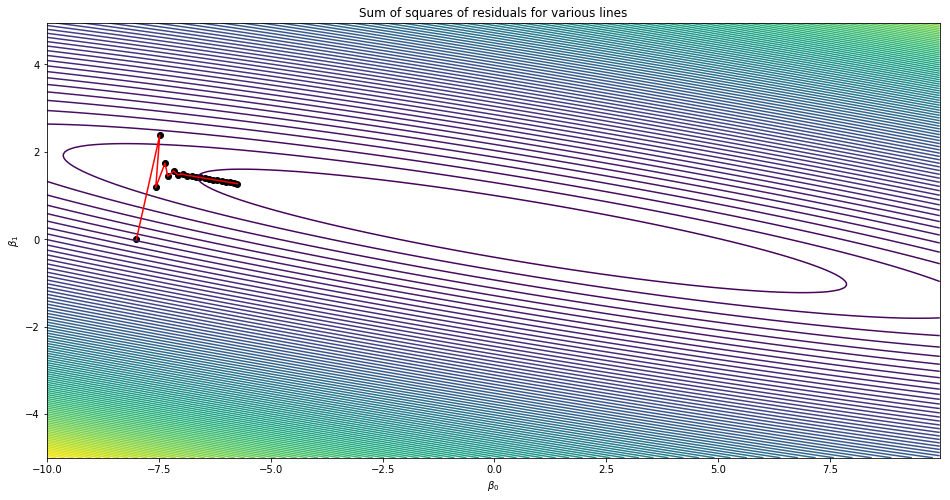

In [10]:
ax.scatter(*np.vstack(points).T, color='k')
ax.plot(*np.vstack(points).T, 'r')
fig

## Limitations and variants of gradient descent

Gradient descent has a few limitations. First, it's dependent on the size of the step. Too small and it takes a long time. Too big...

(-5.0, 4.9499999999999638)

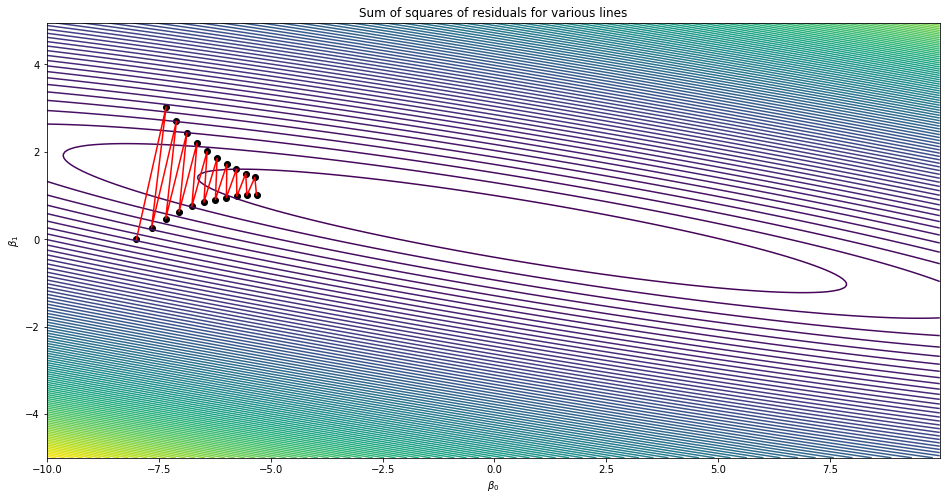

In [11]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.contour(beta0, beta1, loss, np.linspace(loss.min(), loss.max(), 100))
ax.set_xlabel(r"$\beta_0$")
ax.set_ylabel(r"$\beta_1$")
ax.set_title("Sum of squares of residuals for various lines")
points = [np.array((-8,0))]
alpha = 0.0014 ## changed from 0.0011
for _ in range(20):
    points.append(points[-1] -
                  alpha * gradient(points[-1]))

# save values since they will blow up
save_xlim = ax.get_xlim()
save_ylim = ax.get_ylim()
ax.scatter(*np.vstack(points).T, color='k')
ax.plot(*np.vstack(points).T, 'r')
ax.set_xlim(save_xlim)
ax.set_ylim(save_ylim)

If the value of $$\frac{|\nabla f(\mathbf{x}_i) - \nabla f(\mathbf{x}_{i+1})|}{|\mathbf{x}_i-\mathbf{x}_{i+1}|}$$ is bounded above by some number $L(\nabla f)$ then $$\alpha \leq \frac{1}{L(\nabla f)}$$ will converge.

#### Feature scaling 
If the second derivative is the same in all directions it converges pretty well. If the farther it is from this (as above) the more trouble it has converging, because the initial learning rate takes too long to converge along the slower dimensions.

This can mitigated by standardize/normalize the features.

#### Adaptive Step Size

There are various extensions to gradient descent that allow the learning rate to vary. One (from Barzilai and Borwein, 1998) 

Suppose $\mathbf{x}_i$ is the value of $\mathbf{x}$ at the iteration $i$

$\Delta \mathbf{x} = \mathbf{x}_i - \mathbf{x}_{i-1}$

$\Delta g(\mathbf{x}) = \nabla f(\mathbf{x}_i) - \nabla f(\mathbf{x}_{i-1})$

At each step $$\alpha = \frac{\Delta g(\mathbf{x})^T \Delta \mathbf{x}}{||\Delta g(\mathbf{x})||^2}$$ is a good choice of $\alpha$

#### Global minima

Gradient descent is not guaranteed to find find a global minimum, only the local. This isn't a problem here or with logistic regression (there's only one minimum) but is for other problems. Finding the global minimum is a difficult problem that does not have a solution general, though there re techniques that do better than others. One approach is too try multiple starting points and make sure they converge to the same value.

### Convergence Criteria
There are a few choices for the choosing when you're done.

 * $\frac{|f(\mathbf{x}) - f(\mathbf{y})|}{|f(\mathbf{x})|} < \epsilon$
 * Magnitude of gradient $|\nabla f| < \epsilon$
 * Maximum number of iterations

### Gradient Ascent

**Question:** Suppose you need to find a maximum rather than a minimum. How would you do that?

## Stochastic gradient descent

One of the challenges of gradient descent is that it requires all the data to be in memory at each step. That's a problem for Big Data situations when you have more data then can fit in memory.

One solution to this is **stochastic gradient descent** (SGD), in which we make a step for *each data point* (choosen in random order), so we one need one data point in memory at the same time. Since the loss function is the sum of the loss functions associated with each data point, the average effect of a tiny step for each point is the same as one step for the whole sample.

A less extreme alternative is **mini-batch stochastic gradient descent** in which we use a small number of data points for each step.

SGD has a couple other advantages. First, it allowed on-line training; it can incorporate additional data easily and train to that. Second, the random data points help it prevent local minima.

## Newton's method

Newton's Method is an optimization technique that uses the second derivative to jump to the solution more quickly.

Uses a root-finding method applied to $f^{\prime}(x)$
Algorithm in One Dimension
Algorithm

* Choose initial $x_0$
* Repeatedly
    * $x_{i+1} = x_i - \frac{f^{\prime}(x_i)}{f^{\prime\prime}(x_i)}$
    * until  $f^{\prime}(x) < \epsilon$
    
For higher dimensions, change

$$x_{i+1} = x_i - \frac{f^{\prime}(x_i)}{f^{\prime\prime}(x_i)}$$

to

$$\mathbf{y}{i+1} = \mathbf{y}{i} - H(\mathbf{y}_i)^{-1}\nabla f(\mathbf{y}_i)$$

where $H(\mathbf{a}) = \left[\frac{\partial f}{\partial x_i \partial x_j}(\mathbf{a})\right]$ is the Hessian matrix, the matrix of second partial derivatives at $\mathbf{a}$

Newton's method can diverge with a bad starting guess, or fail if the Hessian is singular. More significantly, inverting the the Hessian is computationally expensive in high dimensions.